# Confidence and Choice (FF_estimation) Visualizer

Confidence is based on actual scalar outputs, choice is based on scalar outputs rounded to the nearest integer.

In [1]:
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
from analysis_estimation_nds import classify_imgs_scalar
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

hello sharon
['/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py', '-f', 'true', 'true', 'true', 'true', 'true', 'model_runs/-f/classify_log.csv', 'model_runs/-f/classifymodel_0.ckpt', 'model_runs/-f/classifymodel_', 'model_runs/-f/zzzdraw_data_5000.npy', 'false', 'true', 'false', 'false', 'true']
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
100
numerosity: 1
numerosity: 2
numerosity: 3
numerosity: 4
numerosity: 5
numerosity: 6
numerosity: 7
numerosity: 8
numerosity: 9
numerosity: 10
numerosity: 11
numerosity: 12
numerosity: 13
numerosity: 14
numerosity: 15
analysis_estimation_nds.py


In [2]:
model_name = "New_CAA_const_fN_scalar"
num_runs = 10
iter_list = [0, 200, 400, 1600, 6400, 25600, 102400, 204800, 409600, 819200, 1000000, 1228800, 1638400, 2000000, 3000000]#, 4000000, 5000000, 6000000]
max_blobs = 15
min_blobs = 1

num_iters = len(iter_list)
output_size = max_blobs - min_blobs + 1#15
test_conditions = "variable_position_only"
data_directory = "data/" + model_name + "/" + test_conditions + "/"
m = 0.5

confidence_all_runs = np.zeros([num_runs, num_iters, output_size, output_size]) 
choice_all_runs = np.zeros([num_runs, num_iters, output_size, output_size]) 
num_iters


import os
if not os.path.exists(data_directory):
    os.makedirs(data_directory)

In [3]:
from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file
import os
path = 'model_runs/' + model_name + str(1)
it = 0
checkpoint_path = "%s/classifymodel_%d.ckpt" % (path, it)

# List ALL tensors example output: v0/Adam (DT_FLOAT) [3,3,1,80]
print_tensors_in_checkpoint_file(file_name=checkpoint_path, tensor_name='', all_tensors=False, all_tensor_names=False)

# List contents of v0 tensor.
# Example output: tensor_name:  v0 [[[[  9.27958265e-02   7.40226209e-02   4.52989563e-02   3.15700471e-02
# print_tensors_in_checkpoint_file(file_name=checkpoint_path, tensor_name='hidden/b', all_tensors=False, all_tensor_names=False)


beta1_power (DT_FLOAT) []
beta2_power (DT_FLOAT) []
hidden/b (DT_FLOAT) [250]
hidden/b/Adam (DT_FLOAT) [250]
hidden/b/Adam_1 (DT_FLOAT) [250]
hidden/w (DT_FLOAT) [225,250]
hidden/w/Adam (DT_FLOAT) [225,250]
hidden/w/Adam_1 (DT_FLOAT) [225,250]
output/b (DT_FLOAT) [1]
output/b/Adam (DT_FLOAT) [1]
output/b/Adam_1 (DT_FLOAT) [1]
output/w (DT_FLOAT) [250,1]
output/w/Adam (DT_FLOAT) [250,1]
output/w/Adam_1 (DT_FLOAT) [250,1]



In [4]:
path = 'model_runs/' + model_name + str(1)
imgs_data = classify_imgs_scalar(0, True, 100, path=path)
np.shape(imgs_data[1]["classifications"])

INFO:tensorflow:Restoring parameters from model_runs/New_CAA_const_fN_scalar1/classifymodel_0.ckpt


(1, 1)

In [5]:
def get_classifications_one_run(path, iteration):
    """Get classifications for one run at one iteration."""

    imgs_data = classify_imgs_scalar(iteration, True, 100, path=path) # new_imgs = True
    unrounded_values = {nb: [] for nb in range(1, output_size+1)}
    rounded_values = {nb: [] for nb in range(1, output_size+1)}
    
    for idx, data in enumerate(imgs_data):
        nb = data["label"][0]
        classification = data["classifications"][0][0]
        unrounded_values[nb].append(classification)
        rounded_values[nb].append(round(classification))
    return unrounded_values, rounded_values

In [6]:
unrounded_values_all_runs = []
rounded_values_all_runs = []

for run in range(num_runs):
    path = 'model_runs/' + model_name + str(run + 1) # '/run_' if all the runs are stored in one folder
    unrounded_values_all_iters = []
    rounded_values_all_iters = []
    for i, iteration in enumerate(iter_list):
        uvals, rvals = get_classifications_one_run(path, iteration)
        unrounded_values_all_iters.append(uvals)
        rounded_values_all_iters.append(rvals)
    unrounded_values_all_runs.append(unrounded_values_all_iters)
    rounded_values_all_runs.append(rounded_values_all_iters)
    
with open(data_directory + 'unrounded_values_all_runs', 'wb') as fp:
    pickle.dump(unrounded_values_all_runs, fp)
    
with open(data_directory + 'rounded_values_all_runs', 'wb') as fp:
    pickle.dump(rounded_values_all_runs, fp) 

INFO:tensorflow:Restoring parameters from model_runs/New_CAA_const_fN_scalar1/classifymodel_0.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_const_fN_scalar1/classifymodel_200.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_const_fN_scalar1/classifymodel_400.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_const_fN_scalar1/classifymodel_1600.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_const_fN_scalar1/classifymodel_6400.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_const_fN_scalar1/classifymodel_25600.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_const_fN_scalar1/classifymodel_102400.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_const_fN_scalar1/classifymodel_204800.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_const_fN_scalar1/classifymodel_409600.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_const_fN_scalar1/cl

INFO:tensorflow:Restoring parameters from model_runs/New_CAA_const_fN_scalar6/classifymodel_25600.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_const_fN_scalar6/classifymodel_102400.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_const_fN_scalar6/classifymodel_204800.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_const_fN_scalar6/classifymodel_409600.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_const_fN_scalar6/classifymodel_819200.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_const_fN_scalar6/classifymodel_1000000.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_const_fN_scalar6/classifymodel_1228800.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_const_fN_scalar6/classifymodel_1638400.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_const_fN_scalar6/classifymodel_2000000.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_

In [7]:
def get_msdcv(classifications_list):
    """Get the mean, standard deviation, and coefficient of variation matrices from classifications list."""
    
    msdcv = np.zeros([num_iters, output_size, 3])    
    values = [{nb: [] for nb in range(1, output_size+1)} for i in range(num_iters)] # iter x nb x value
    for run in range(num_runs):
        for i in range(num_iters):
            for t in range(output_size):
                nb = t + 1
                if nb in classifications_list[run][i]:
                    values[i][nb] += classifications_list[run][i][nb]
    for i in range(num_iters):
        for t in range(output_size):
            nb = t + 1
            vals = values[i][nb]
            msdcv[i, t, 0] = mu = np.mean(vals)
            msdcv[i, t, 1] = sigma = np.std(vals)
            msdcv[i, t, 2] = cv = sigma / mu
    return msdcv

In [8]:
unrounded_msdcv = get_msdcv(unrounded_values_all_runs)
rounded_msdcv = get_msdcv(rounded_values_all_runs)

In [9]:
np.save(data_directory + "unrounded_msdcv", unrounded_msdcv)
np.save(data_directory + "rounded_msdcv", rounded_msdcv)

## Visualize Mean, Standard Deviation, and Coefficient of Variation

Run 20200202_Plot_MSDCV_scalar.ipynb to get plots. Below is an example plot.

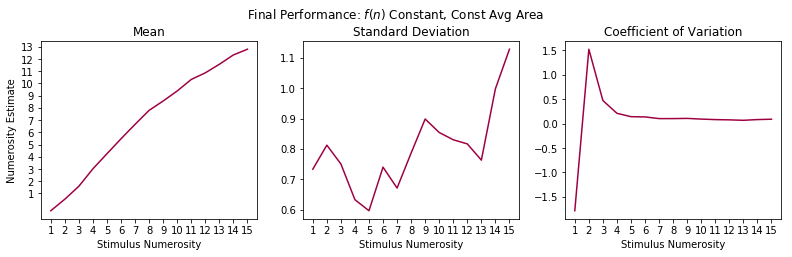

In [10]:
all_iters = [0, 200, 400, 1600, 6400, 6400, 102400, 204800, 409600, 819200, 1000000, 1228800, 1638400, 2000000, 3000000]#, 4000000, 5000000, 6000000]
iters = [3000000]
iter_indices = [i for i, iteration in enumerate(all_iters) if iteration in iters]
max_blobs = 15
min_blobs = 1
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(3.7*3, 3.6))
from matplotlib.ticker import MaxNLocator
plt.xticks(np.arange(min_blobs, max_blobs+1, step=1))
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[2].xaxis.set_major_locator(MaxNLocator(integer=True))
numerosity = np.arange(min_blobs, max_blobs+1)

ax[0].set_title("Mean")
ax[0].set_xlabel("Stimulus Numerosity")
ax[0].set_ylabel("Numerosity Estimate")
ax[0].set_yticks(np.arange(min_blobs, max_blobs+1, step=1))
ax[0].set_xticks(np.arange(min_blobs, max_blobs+1, step=1))
ax[0].set_prop_cycle('color',plt.cm.Spectral([val for val in np.linspace(0,1,len(iter_indices)) for _ in (0,1)]))

ax[1].set_title("Standard Deviation")
ax[1].set_xlabel("Stimulus Numerosity")
ax[1].set_xticks(np.arange(min_blobs, max_blobs+1, step=1))
ax[1].set_prop_cycle('color',plt.cm.Spectral([val for val in np.linspace(0,1,len(iter_indices)) for _ in (0,1)]))

ax[2].set_title("Coefficient of Variation")
ax[2].set_xlabel("Stimulus Numerosity")
# ax[2].set_yticks(np.arange(0, 1, step=0.02))
ax[2].set_xticks(np.arange(min_blobs, max_blobs+1, step=1))
ax[2].set_prop_cycle('color',plt.cm.Spectral([val for val in np.linspace(0,1,len(iter_indices)) for _ in (0,1)]))

for i in iter_indices:
    mean = unrounded_msdcv[i,min_blobs-1:max_blobs,0]
    sd = unrounded_msdcv[i,min_blobs-1:max_blobs+1,1]
    cv = unrounded_msdcv[i,min_blobs-1:max_blobs+1,2]

    # Plot Mean.
    ax[0].plot(numerosity, mean, label='N')
    
    # Plot CV.
    ax[1].plot(numerosity, sd, label='N')
    
    # Plot CV.
    ax[2].plot(numerosity, cv, label='N')

# legend = ax[i, 1].legend()
fig.tight_layout()    
# fig.suptitle("Final Performance: $f(n) \propto 1/n^2$, Decr Avg Area")
# fig.suptitle("Final Performance: $f(n) \propto 1/n^2$, Const Avg Area")
# fig.suptitle("Final Performance: $f(n)$ Constant, Decr Avg Area")
fig.suptitle("Final Performance: $f(n)$ Constant, Const Avg Area")
plt.tight_layout(rect=[0, 0, 1, 0.95])
from pathlib import Path
results_dir = 'Results/20200202_msdcv_3000000_scalar/'
Path(results_dir).mkdir(parents=True, exist_ok=True)
plt.savefig(results_dir + model_name + '.png')
plt.show()